<a href="https://colab.research.google.com/github/richardOlson/nlp__tranformers/blob/main/Sentiment_analysis_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The steps for doing the NLP are:
1. Data Preprocessing
2. Make an Input Pipeline
3. Building and Training.
4. Making the predicctions.

In [1]:
import tensorflow as tf
# will be using the kaggle api to get the data
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olsonr","key":"04b69adac2165dff96fec1ab695f9762"}'}

In [4]:
# copying the kaggle json into the folder that was made 
# for it.
! cp kaggle.json ~/.kaggle/

In [5]:
# changing the permissions
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [8]:
api = KaggleApi()

In [9]:
api.authenticate()

In [13]:
api.competition_download_file("sentiment-analysis-on-movie-reviews",
                             "test.tsv.zip",
                             path="./")
#api.competition_download_files("sentiment-analysis-on-movie-reviews",
#                              path="./")
api.competition_download_file("sentiment-analysis-on-movie-reviews",
                              "train.tsv.zip", path="./")

test.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


100%|██████████| 1.28M/1.28M [00:00<00:00, 112MB/s]

In [14]:
import zipfile

In [15]:
with zipfile.ZipFile("./test.tsv.zip", "r",) as zipRef:
  zipRef.extractall("./")
with zipfile.ZipFile("./train.tsv.zip", "r") as zipRef:
  zipRef.extractall("./")


In [24]:
# reading in the data
import pandas as pd
import matplotlib.pyplot as plt



In [18]:
train = pd.read_csv("./train.tsv", sep="\t", )
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


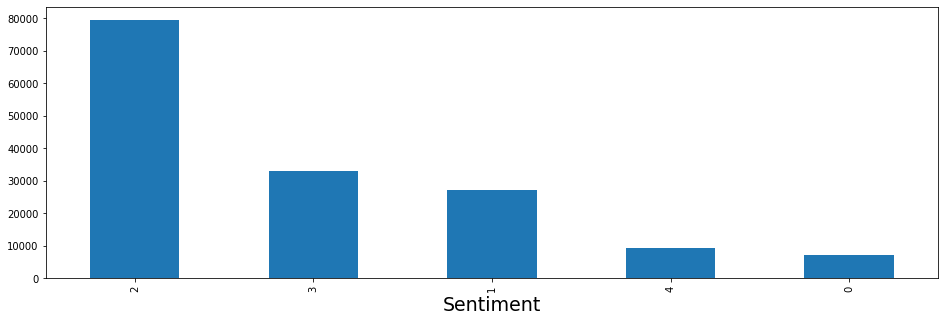

In [29]:
plt.xlabel("Sentiment", size=19)
train['Sentiment'].value_counts().plot(kind="bar", figsize=(16,5), )